In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy.optimize import least_squares

In [29]:
#function to calculate the projective homography between two images
def proj_homography(dcord,rcord):
    A = np.zeros((8,8))
    B = np.zeros((8,1))
    H = np.ones((3,3))
 
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(4):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
 
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
 
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
 
 
    C = np.dot(np.linalg.pinv(A),B);
 
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
 
    return H


In [30]:
#function to calculate the homography between two images using inhomogeneous linear least square
def LLS_homography(dcord,rcord):
    n = dcord.shape[0]
    A = np.zeros((2*n,8))
    B = np.zeros((2*n,1))
    H = np.ones((3,3))
 
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(n):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
 
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
 
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
 
 
    C = np.dot(np.matmul(np.linalg.pinv(A.T@A),A.T),B);
 
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
 
    return H


In [31]:
#obtaining the (x,y) coordinates from a keypoint
def coords(good,kp1,kp2):
    coord1=[]
    coord2=[]
    
    for i in good:
        idx1 = i[0].queryIdx
        idx2 = i[0].trainIdx
        
        t1 = kp1[idx1].pt
        t2 = kp2[idx2].pt
        
        coord1.append([t1[0],t1[1]])
        coord2.append([t2[0],t2[1]])
        
    return coord1,coord2
        
    
    

In [32]:
#Returns the inliers for a given homography H
def theinliers(H,im1,im2,delta):
    him1 = np.insert(im1,2,1,axis=1)
    him2 = np.insert(im2,2,1,axis=1)
    
    him2_calc = np.matmul(H,him1.T)
    im2_calc = him2_calc/him2_calc[2,:]
    im2_calc = im2_calc[0:2,:].T
    error  = np.abs(im2-im2_calc)
    t_error = np.sum(error**2,axis=1)
    
    idx = np.where(t_error<delta)[0]
    
    return idx
    

In [33]:
#Implementation of RANSAC and resultant homography is refined using inbulit LM method
def RANSAC(good,kp1,kp2):
    delta = 3.0
    p = 0.99
    epsilon = 0.25
    n = 4
    ntotal = len(good)
    N = np.log(1-p)/np.log(1-(1-epsilon)**n)
    N = int(N)
    M = (1-epsilon)*ntotal
    
    Im1,Im2 = coords(good,kp1,kp2)
    im1 = np.asarray(Im1)
    im2 = np.asarray(Im2)
    
    most_inliers = []
    max_inliers=0
    
    for i in range(N):
        idx = np.random.choice(list(range(ntotal)),n)
        
        Dcord=[]
        Rcord=[]
        for j in idx:
            Dcord.append(im1[j])
            Rcord.append(im2[j])
        dcord = np.asarray(Dcord)
        rcord = np.asarray(Rcord)
        H = proj_homography(dcord,rcord)
        inliers = theinliers(H,im1,im2,delta**2)
        if len(inliers)>M and len(inliers)>max_inliers:
            max_inliers = len(inliers)
            most_inliers = inliers
            
    H_final = LLS_homography(im1[most_inliers],im2[most_inliers])
    H_finals = LM_inbuilt(im1[most_inliers],im2[most_inliers],H_final)
        
    return H_finals,most_inliers
               

    
    

In [34]:
#Generates the panorama
def stiching(panorama, dimg, H):
    height, width, _ = panorama.shape
    h,w,_ = dimg.shape
    
    H = np.linalg.pinv(H)
    
    xx,yy = np.meshgrid(np.arange(0,width-1),np.arange(0,height-1))
    rcoords = np.vstack((xx.reshape(-1),yy.reshape(-1))).T
    ones = np.ones((rcoords.shape[0],1),np.uint8)
    hcoords = np.append(rcoords,ones,axis=1)
    
    dcoords = H@hcoords.T
    dcoords = dcoords/dcoords[2,:]
    dcoords = dcoords[0:2,:].T.astype('int')
    
    vrcoord,vdcoord = inbound_points(rcoords,dcoords,h-1,w-1)
    flag = 0
    for i in range(vdcoord.shape[0]):
        if(np.all(panorama[vrcoord[i,1],vrcoord[i,0]])==0):
            panorama[vrcoord[i,1],vrcoord[i,0]] = dimg[vdcoord[i,1],vdcoord[i,0]]
    
    return panorama


In [35]:
#Removing the coordinates which lie outside the shape of the domain image
def inbound_points(rcoord,dcoord,h,w):
    
    minx = dcoord[:,0] >= 0
    dcoord = dcoord[minx,:]
    rcoord = rcoord[minx,:]
    
  
    miny = dcoord[:,1] >= 0
    dcoord = dcoord[miny,:]
    rcoord = rcoord[miny,:]
    
    maxx = dcoord[:,0] <= w
    dcoord = dcoord[maxx,:]
    rcoord =  rcoord[maxx,:]
    
    maxy = dcoord[:,1] <= h
    dcoord = dcoord[maxy,:]
    rcoord =  rcoord[maxy,:]
    
    return rcoord,dcoord
    
    
    

In [36]:
#Cost function of LM method
def cost_LM(h,dcoord,rcoord):
    H = h.reshape((3,3))
    hdcoord = np.insert(dcoord,2,1,axis=1)
    hrcoord = np.insert(rcoord,2,1,axis=1)
    
    hrcoord_calc = np.matmul(H,hdcoord.T)
    hrcoord_calc = hrcoord_calc/hrcoord_calc[2,:]
    hrcoord_calc = hrcoord_calc.T
    cost  = np.abs(hrcoord-hrcoord_calc)
    
    return cost.sum(axis=1)**2
    

In [37]:
#Inbuilt LM function
def LM_inbuilt(dcoord,rcoord,H):
    h  = H.flatten()
    LM = least_squares(cost_LM,h,args=(dcoord,rcoord),method="lm")
    h_LM = LM.x
    H_LM = h_LM.reshape((3,3))
    return H_LM
    

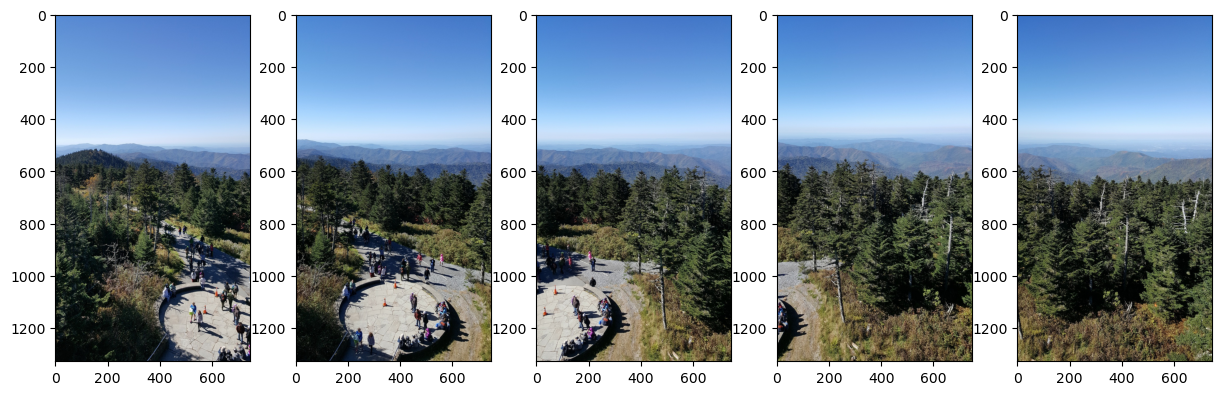

In [38]:
#displaying the five images of the same scene
oimga = cv2.imread ("0.jpg")
oimgb = cv2.imread ("1.jpg")
oimgc = cv2.imread ("2.jpg")
oimgd = cv2.imread ("3.jpg")
oimge = cv2.imread ("4.jpg")

cimga = cv2.cvtColor(oimga, cv2.COLOR_BGR2RGB)
cimgb = cv2.cvtColor(oimgb, cv2.COLOR_BGR2RGB)
cimgc = cv2.cvtColor(oimgc, cv2.COLOR_BGR2RGB)
cimgd = cv2.cvtColor(oimgd, cv2.COLOR_BGR2RGB)
cimge = cv2.cvtColor(oimge, cv2.COLOR_BGR2RGB)


f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(151)
ax2 = f.add_subplot(152)
ax3 = f.add_subplot(153)
ax4 = f.add_subplot(154)
ax5 = f.add_subplot(155)

ax1.imshow(cimga)
ax2.imshow(cimgb)
ax3.imshow(cimgc)
ax4.imshow(cimgd)
ax5.imshow(cimge)

True

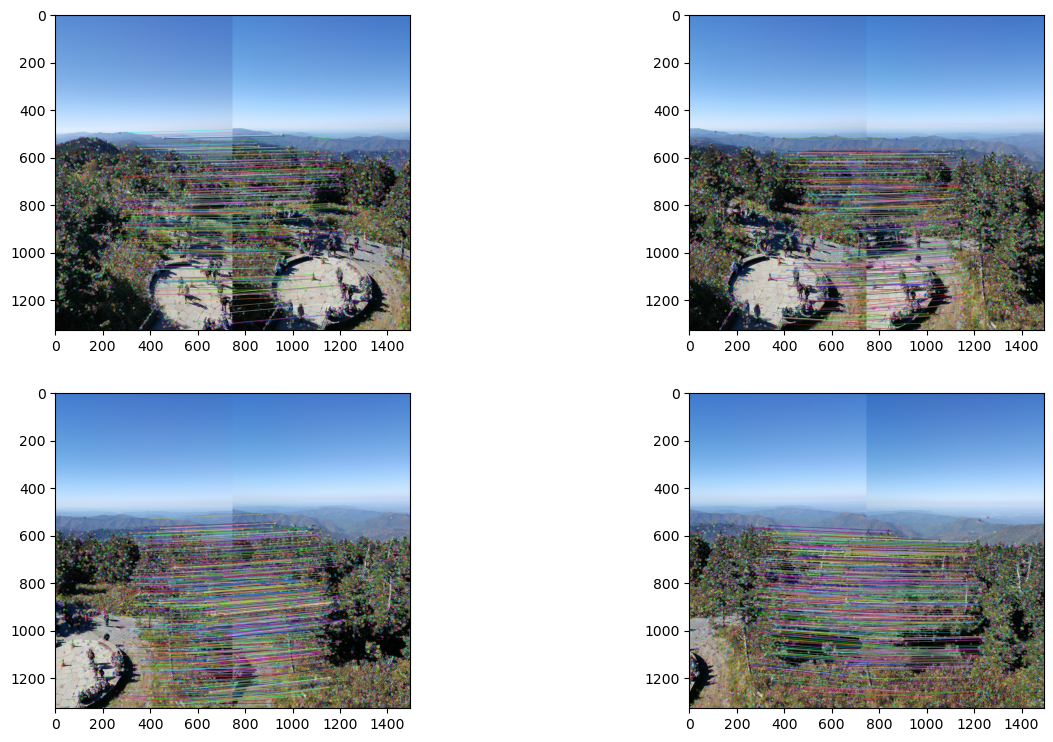

In [39]:
#displaying the correspondences between consecutive pairs
sift = cv2.SIFT_create()

gimga = cv2.cvtColor(oimga, cv2.COLOR_BGR2GRAY)
gimgb = cv2.cvtColor(oimgb, cv2.COLOR_BGR2GRAY)
gimgc = cv2.cvtColor(oimgc, cv2.COLOR_BGR2GRAY)
gimgd = cv2.cvtColor(oimgd, cv2.COLOR_BGR2GRAY)
gimge = cv2.cvtColor(oimge, cv2.COLOR_BGR2GRAY)


kp1, des1 = sift.detectAndCompute(gimga,None)
kp2, des2 = sift.detectAndCompute(gimgb,None)
kp3, des3 = sift.detectAndCompute(gimgc,None)
kp4, des4 = sift.detectAndCompute(gimgd,None)
kp5, des5 = sift.detectAndCompute(gimge,None)


bf = cv2.BFMatcher()
matches12 = bf.knnMatch(des1,des2, k=2)
matches23 = bf.knnMatch(des2,des3, k=2)
matches34 = bf.knnMatch(des3,des4, k=2)
matches45 = bf.knnMatch(des4,des5, k=2)

# The ratio test
good12 = []
good23 = []
good34 = []
good45 = []

for m,n in matches12:
    if m.distance < 0.5*n.distance:
        good12.append([m])

for m,n in matches23:
    if m.distance < 0.5*n.distance:
        good23.append([m])
        
for m,n in matches34:
    if m.distance < 0.5*n.distance:
        good34.append([m])
        
for m,n in matches45:
    if m.distance < 0.5*n.distance:
        good45.append([m])
        
allcorr12 = cv2.drawMatchesKnn(cimga,kp1,cimgb,kp2,good12, None,matchColor=(-1, -1, -1), matchesMask=None,singlePointColor=(-1, -1, -1), flags=0)
allcorr23 = cv2.drawMatchesKnn(cimgb,kp2,cimgc,kp3,good23, None,matchColor=(-1, -1, -1), matchesMask=None,singlePointColor=(-1, -1, -1), flags=0)
allcorr34 = cv2.drawMatchesKnn(cimgc,kp3,cimgd,kp4,good34, None,matchColor=(-1, -1, -1), matchesMask=None,singlePointColor=(-1, -1, -1), flags=0)
allcorr45 = cv2.drawMatchesKnn(cimgd,kp4,cimge,kp5,good45, None,matchColor=(-1, -1, -1), matchesMask=None,singlePointColor=(-1, -1, -1), flags=0)

f = plt.figure(figsize=(15,9))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.imshow(allcorr12)
ax2.imshow(allcorr23)
ax3.imshow(allcorr34)
ax4.imshow(allcorr45)

allcorr12 = cv2.cvtColor(allcorr12, cv2.COLOR_RGB2BGR)
allcorr23 = cv2.cvtColor(allcorr23, cv2.COLOR_RGB2BGR)
allcorr34 = cv2.cvtColor(allcorr34, cv2.COLOR_RGB2BGR)
allcorr45 = cv2.cvtColor(allcorr45, cv2.COLOR_RGB2BGR)

cv2.imwrite("allcorr12.jpg",allcorr12)
cv2.imwrite("allcorr23.jpg",allcorr23)
cv2.imwrite("allcorr34.jpg",allcorr34)
cv2.imwrite("allcorr45.jpg",allcorr45)

In [43]:
#Obtaining the Homographies between successive pairs of images and their inliers
H12, inliers12 = RANSAC(good12,kp1,kp2)
H23, inliers23 = RANSAC(good23,kp2,kp3)
H34, inliers34 = RANSAC(good34,kp3,kp4)
H45, inliers45 = RANSAC(good45,kp4,kp5)



In [44]:
H45

array([[ 9.69873095e-01,  2.25931617e-02, -2.59571451e+02],
       [ 1.13500377e-01,  9.13659014e-01, -3.89633772e+01],
       [ 2.32759806e-04, -3.69334846e-06,  8.02106973e-01]])

In [45]:
#Calculating the Homographies between a given image and the middle image
width = cimga.shape[1]+cimgb.shape[1]+cimgc.shape[1]+cimgd.shape[1]+cimge.shape[1]
height = max(cimga.shape[0],cimgb.shape[0],cimgc.shape[0],cimgd.shape[0],cimge.shape[0])
panorama = np.zeros((height,width,3),np.uint8)

H_translate = np.eye(3,3)
H_translate[0,2] = cimga.shape[1]+cimgb.shape[1]

H13 = H12@H23
H33 = np.eye(3,3)
H43 = np.linalg.pinv(H34)
H53 = np.linalg.pinv(H34@H45)

H_overall = [H13,H23,H33,H43,H53]
cimage = [cimga,cimgb,cimgc,cimgd,cimge]




True

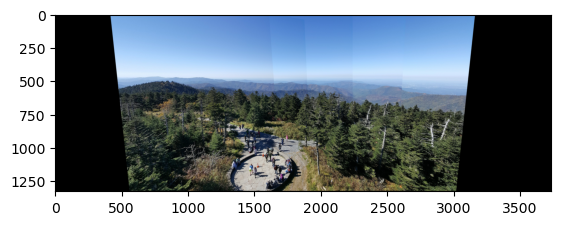

In [46]:
#Generating the panorama
for i in range(5):
    panorama = stiching(panorama,cimage[i], H_translate@H_overall[i])

plt.imshow(panorama)

panorama = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)
cv2.imwrite("panorama.jpg",panorama)

True

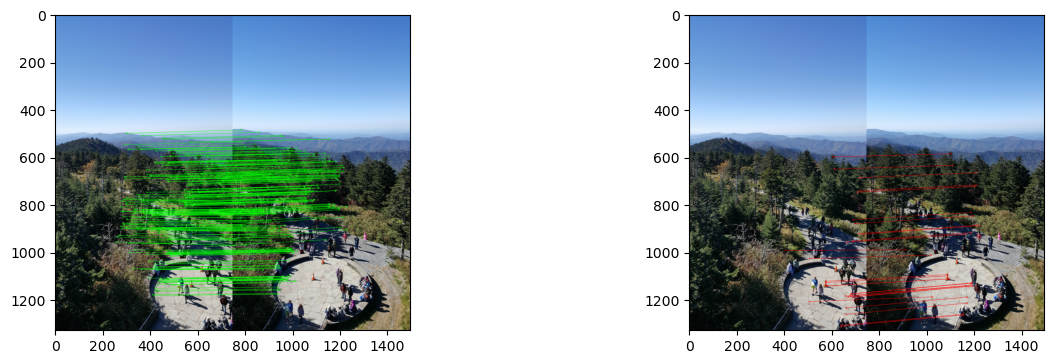

In [24]:
#showcasing the inliers and outlier correspondences
outliers12 = np.setdiff1d(np.arange(0,len(good12)), inliers12, assume_unique=False)
temp12 = np.asarray(good12)
in12  = temp12[inliers12]
out12 = temp12[outliers12]

ain12  = in12.tolist()
aout12  = out12.tolist()

inlierimg12 = cv2.drawMatchesKnn(cimga,kp1,cimgb,kp2,ain12, None,matchColor=(0, 255, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)
outlierimg12 = cv2.drawMatchesKnn(cimga,kp1,cimgb,kp2,aout12, None,matchColor=(255, 0, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)

f = plt.figure(figsize=(15,9))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)

ax1.imshow(inlierimg12)
ax2.imshow(outlierimg12)

inlierimg12 = cv2.cvtColor(inlierimg12, cv2.COLOR_RGB2BGR)
outlierimg12 = cv2.cvtColor(outlierimg12, cv2.COLOR_RGB2BGR)

cv2.imwrite("inlierimg12.jpg",inlierimg12)
cv2.imwrite("outlierimg12.jpg",outlierimg12)




True

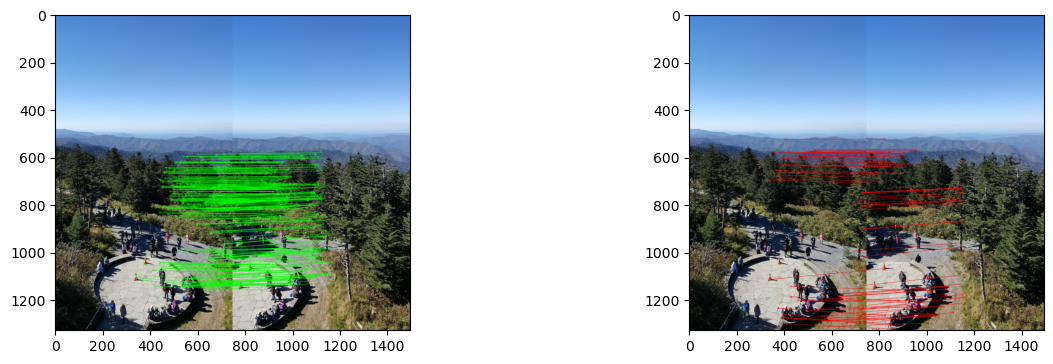

In [25]:
#showcasing the inliers and outlier correspondences
outliers23 = np.setdiff1d(np.arange(0,len(good23)), inliers23, assume_unique=False)
temp23 = np.asarray(good23)
in23  = temp23[inliers23]
out23 = temp23[outliers23]

ain23  = in23.tolist()
aout23  = out23.tolist()

inlierimg23 = cv2.drawMatchesKnn(cimgb,kp2,cimgc,kp3,ain23, None,matchColor=(0, 255, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)
outlierimg23 = cv2.drawMatchesKnn(cimgb,kp2,cimgc,kp3,aout23, None,matchColor=(255, 0, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)

f = plt.figure(figsize=(15,9))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)

ax1.imshow(inlierimg23)
ax2.imshow(outlierimg23)

inlierimg23 = cv2.cvtColor(inlierimg23, cv2.COLOR_RGB2BGR)
outlierimg23 = cv2.cvtColor(outlierimg23, cv2.COLOR_RGB2BGR)
cv2.imwrite("inlierimg23.jpg",inlierimg23)
cv2.imwrite("outlierimg23.jpg",outlierimg23)


True

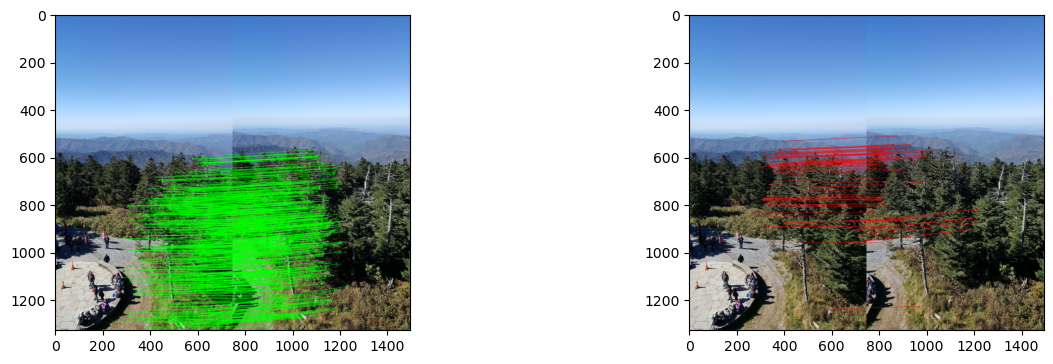

In [26]:
#showcasing the inliers and outlier correspondences
outliers34 = np.setdiff1d(np.arange(0,len(good34)), inliers34, assume_unique=False)
temp34 = np.asarray(good34)
in34  = temp34[inliers34]
out34 = temp34[outliers34]

ain34  = in34.tolist()
aout34  = out34.tolist()

inlierimg34 = cv2.drawMatchesKnn(cimgc,kp3,cimgd,kp4,ain34, None,matchColor=(0, 255, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)
outlierimg34 = cv2.drawMatchesKnn(cimgc,kp3,cimgd,kp4,aout34, None,matchColor=(255, 0, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)

f = plt.figure(figsize=(15,9))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)

ax1.imshow(inlierimg34)
ax2.imshow(outlierimg34)

inlierimg34 = cv2.cvtColor(inlierimg34, cv2.COLOR_RGB2BGR)
outlierimg34 = cv2.cvtColor(outlierimg34, cv2.COLOR_RGB2BGR)
cv2.imwrite("inlierimg34.jpg",inlierimg34)
cv2.imwrite("outlierimg34.jpg",outlierimg34)


True

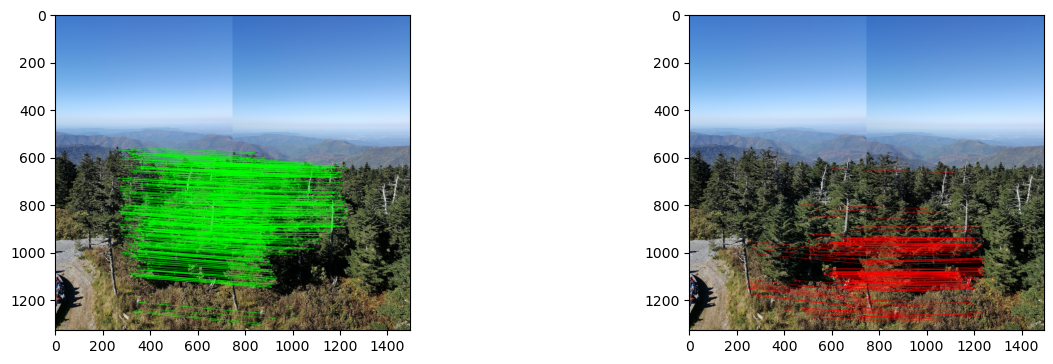

In [27]:
#showcasing the inliers and outlier correspondences
outliers45 = np.setdiff1d(np.arange(0,len(good45)), inliers45, assume_unique=False)
temp45 = np.asarray(good45)
in45  = temp45[inliers45]
out45 = temp45[outliers45]

ain45  = in45.tolist()
aout45  = out45.tolist()

inlierimg45 = cv2.drawMatchesKnn(cimgd,kp4,cimge,kp5,ain45, None,matchColor=(0, 255, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)
outlierimg45 = cv2.drawMatchesKnn(cimgd,kp4,cimge,kp5,aout45, None,matchColor=(255, 0, 0), matchesMask=None,singlePointColor=(-1, -1, -1), flags=2)

f = plt.figure(figsize=(15,9))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)

ax1.imshow(inlierimg45)
ax2.imshow(outlierimg45)

inlierimg45 = cv2.cvtColor(inlierimg45, cv2.COLOR_RGB2BGR)
outlierimg45 = cv2.cvtColor(outlierimg45, cv2.COLOR_RGB2BGR)
cv2.imwrite("inlierimg45.jpg",inlierimg45)
cv2.imwrite("outlierimg45.jpg",outlierimg45)
